In [1]:
from imblearn.under_sampling import RandomUnderSampler  
from imblearn.ensemble import BalancedRandomForestClassifier 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import stats
import plotly.express as px
import plotly.figure_factory as ff
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from imblearn.under_sampling import RandomUnderSampler  
from imblearn.ensemble import BalancedRandomForestClassifier  
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

#### REload dataset

In [2]:
SCDHT=pd.read_csv('Synthetic CDHT.csv')

In [3]:
SCDHT.head(5)

,Age,Sex,Cholesterol,Blood Pressure,Heart Rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,...,BMI,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk,Systolic_BP,Diastolic_BP,HT,Blood_Pressure_Status,CD
0,76,0,325,94/109,80,1,1,0,1,1,...,30.947725,97,6,7,0,140,85,1,High,1
1,78,0,164,176/77,86,0,0,1,0,1,...,32.691358,55,2,4,0,130,87,0,Low,1
2,78,1,124,176/77,105,1,0,1,1,1,...,18.453584,324,7,4,0,126,81,1,High,1
3,54,1,362,106/64,103,1,1,1,0,0,...,29.302218,377,7,7,1,112,93,1,High,1
4,65,0,372,176/77,45,1,0,1,0,1,...,35.033226,157,1,7,0,125,74,0,Low,1


In [4]:
SCDHT = SCDHT.drop(columns=['Blood Pressure'])

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
SCDHT['Blood_Pressure_Status'] = le.fit_transform(SCDHT['Blood_Pressure_Status'])


### For handling class imbalance using undersampling

In [6]:
# Converting  categorical variables (if necessary, like 'Sex' and 'Blood_Pressure_Status')
SCDHT_encoded = pd.get_dummies(SCDHT, drop_first=True)
X_CD = SCDHT_encoded.drop(columns=['CD', 'HT'])
y_CD = SCDHT_encoded['CD']

X_HT = SCDHT_encoded.drop(columns=['CD', 'HT'])
y_HT = SCDHT_encoded['HT']
# For CD
under_sampler_cd = RandomUnderSampler(random_state=42)
X_resampled_CD, y_resampled_CD = under_sampler_cd.fit_resample(X_CD, y_CD)
# For HT
under_sampler_ht = RandomUnderSampler(random_state=42)
X_resampled_HT, y_resampled_HT = under_sampler_ht.fit_resample(X_HT, y_HT)
#  Train-Test Split on Resampled Data
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(X_resampled_CD, y_resampled_CD, test_size=0.2, random_state=42)
X_train_HT, X_test_HT, y_train_HT, y_test_HT = train_test_split(X_resampled_HT, y_resampled_HT, test_size=0.2, random_state=42)
# Step 5: Scale the features
scaler = StandardScaler()
X_train_CD_scaled = scaler.fit_transform(X_train_CD)
X_test_CD_scaled = scaler.transform(X_test_CD)
X_train_HT_scaled = scaler.fit_transform(X_train_HT)
X_test_HT_scaled = scaler.transform(X_test_HT)
# Train the Voting Classifier (with Balanced Random Forest and others)
log_clf = LogisticRegression()
brf_clf = BalancedRandomForestClassifier(random_state=42)  # Balanced Random Forest
svm_clf = SVC(probability=True, random_state=42)
knn_clf = KNeighborsClassifier()
gb_clf = GradientBoostingClassifier(random_state=42)
# Voting classifier for CD
voting_clf_CD = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('brf', brf_clf),
    ('svm', svm_clf),
    ('knn', knn_clf),
    ('gb', gb_clf)
], voting='soft')
# Voting classifier for HT
voting_clf_HT = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('brf', brf_clf),
    ('svm', svm_clf),
    ('knn', knn_clf),
    ('gb', gb_clf)
], voting='soft')
# Train for CD
voting_clf_CD.fit(X_train_CD_scaled, y_train_CD)
# Train for HT
voting_clf_HT.fit(X_train_HT_scaled, y_train_HT)
#  Evaluate the models
# For CD
y_pred_CD = voting_clf_CD.predict(X_test_CD_scaled)
print(f'Test accuracy for CD: {accuracy_score(y_test_CD, y_pred_CD):.2f}')
print(classification_report(y_test_CD, y_pred_CD))
print(confusion_matrix(y_test_CD, y_pred_CD))
# For HT
y_pred_HT = voting_clf_HT.predict(X_test_HT_scaled)
print(f'Test accuracy for HT: {accuracy_score(y_test_HT, y_pred_HT):.2f}')
print(classification_report(y_test_HT, y_pred_HT))
print(confusion_matrix(y_test_HT, y_pred_HT))

C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and ad

Test accuracy for CD: 0.91
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       345
           1       0.91      0.88      0.90       292

    accuracy                           0.91       637
   macro avg       0.91      0.91      0.91       637
weighted avg       0.91      0.91      0.91       637

[[321  24]
 [ 34 258]]
Test accuracy for HT: 0.97
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3954
           1       0.97      0.97      0.97      3960

    accuracy                           0.97      7914
   macro avg       0.97      0.97      0.97      7914
weighted avg       0.97      0.97      0.97      7914

[[3850  104]
 [  99 3861]]


####  Performing Cross Validation 

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # 
# Cross-Validation for CD (with Voting Classifier)
print("Performing 5-Fold Cross-Validation for Coronary Disease (CD)...")
cv_scores_CD = cross_val_score(voting_clf_CD, X_train_CD_scaled, y_train_CD, cv=kf, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores for CD: {cv_scores_CD}')
print(f'Mean Cross-Validation Accuracy for CD: {np.mean(cv_scores_CD):.2f}')

# Cross-Validation for HT (with Voting Classifier)
print("Performing 5-Fold Cross-Validation for Hypertension (HT)...")
cv_scores_HT = cross_val_score(voting_clf_HT, X_train_HT_scaled, y_train_HT, cv=kf, scoring='accuracy')
print(f'Cross-Validation Accuracy Scores for HT: {cv_scores_HT}')
print(f'Mean Cross-Validation Accuracy for HT: {np.mean(cv_scores_HT):.2f}')
# Train for CD
voting_clf_CD.fit(X_train_CD_scaled, y_train_CD)
# Train for HT
voting_clf_HT.fit(X_train_HT_scaled, y_train_HT)
# For CD
y_pred_CD = voting_clf_CD.predict(X_test_CD_scaled)
print(f'Test accuracy for CD: {accuracy_score(y_test_CD, y_pred_CD):.2f}')
print(classification_report(y_test_CD, y_pred_CD))
print(confusion_matrix(y_test_CD, y_pred_CD))
# For HT
y_pred_HT = voting_clf_HT.predict(X_test_HT_scaled)
print(f'Test accuracy for HT: {accuracy_score(y_test_HT, y_pred_HT):.2f}')
print(classification_report(y_test_HT, y_pred_HT))
print(confusion_matrix(y_test_HT, y_pred_HT))

Performing 5-Fold Cross-Validation for Coronary Disease (CD)...


C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and ad

Cross-Validation Accuracy Scores for CD: [0.92745098 0.90784314 0.89980354 0.91355599 0.90373281]
Mean Cross-Validation Accuracy for CD: 0.91
Performing 5-Fold Cross-Validation for Hypertension (HT)...


C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and ad

Cross-Validation Accuracy Scores for HT: [0.96951508 0.9701469  0.97567141 0.97630332 0.97409163]
Mean Cross-Validation Accuracy for HT: 0.97


C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and ad

Test accuracy for CD: 0.91
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       345
           1       0.91      0.88      0.90       292

    accuracy                           0.91       637
   macro avg       0.91      0.91      0.91       637
weighted avg       0.91      0.91      0.91       637

[[321  24]
 [ 34 258]]
Test accuracy for HT: 0.97
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3954
           1       0.97      0.97      0.97      3960

    accuracy                           0.97      7914
   macro avg       0.97      0.97      0.97      7914
weighted avg       0.97      0.97      0.97      7914

[[3850  104]
 [  99 3861]]


#### Training vs Testing Accuracy for seing that the model is overfit or generlaised

In [8]:
#  Evaluate training accuracy
y_train_pred_CD = voting_clf_CD.predict(X_train_CD_scaled)
train_accuracy_CD = accuracy_score(y_train_CD, y_train_pred_CD)
y_train_pred_HT = voting_clf_HT.predict(X_train_HT_scaled)
train_accuracy_HT = accuracy_score(y_train_HT, y_train_pred_HT)
print(f'Training accuracy for CD: {train_accuracy_CD:.2f}')
print(f'Training accuracy for HT: {train_accuracy_HT:.2f}')
#Comparing with test accuracy
y_pred_CD = voting_clf_CD.predict(X_test_CD_scaled)
test_accuracy_CD = accuracy_score(y_test_CD, y_pred_CD)
y_pred_HT = voting_clf_HT.predict(X_test_HT_scaled)
test_accuracy_HT = accuracy_score(y_test_HT, y_pred_HT)
print(f'Test accuracy for CD: {test_accuracy_CD:.2f}')
print(f'Test accuracy for HT: {test_accuracy_HT:.2f}')

Training accuracy for CD: 0.95
Training accuracy for HT: 0.97
Test accuracy for CD: 0.91
Test accuracy for HT: 0.97


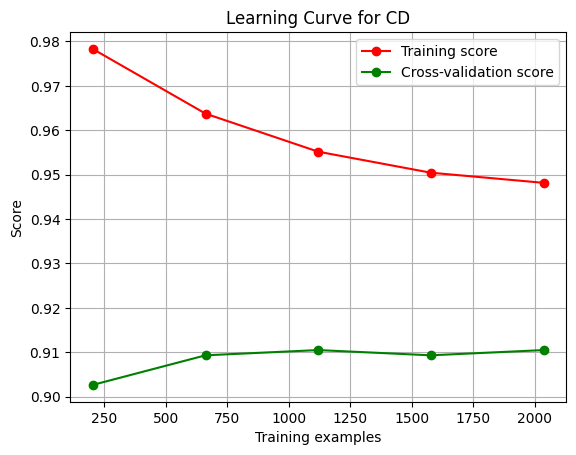

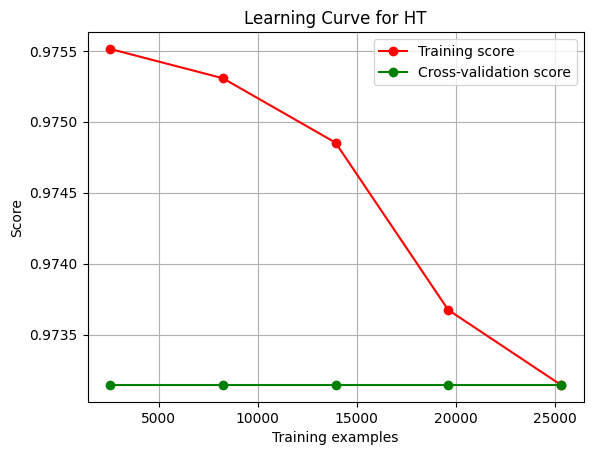

In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(estimator, X, y, cv=5, scoring='accuracy', n_jobs=-1)
    train_scores_mean = train_scores.mean(axis=1)
    val_scores_mean = val_scores.mean(axis=1)
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, val_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()
# Plot learning curve for CD model
plot_learning_curve(voting_clf_CD, X_train_CD_scaled, y_train_CD, title="Learning Curve for CD")
# Plot learning curve for HT model
plot_learning_curve(voting_clf_HT, X_train_HT_scaled, y_train_HT, title="Learning Curve for HT")

 # For handling class imbalance using undersampling +  Randomized Search for Hyperparameter Tuninng (Sample model without selecting a feature )

In [10]:
# Convert categorical variables ( like 'Sex' and 'Blood_Pressure_Status')
SCDHT_encoded = pd.get_dummies(SCDHT, drop_first=True)
# Separated features (X) and target (y) for both CD and HT
X_CD = SCDHT_encoded.drop(columns=['CD', 'HT'])
y_CD = SCDHT_encoded['CD']
X_HT = SCDHT_encoded.drop(columns=['CD', 'HT'])
y_HT = SCDHT_encoded['HT']
# Apply RandomUnderSampler to handle class imbalance
under_sampler_cd = RandomUnderSampler(random_state=42)
X_resampled_CD, y_resampled_CD = under_sampler_cd.fit_resample(X_CD, y_CD)
under_sampler_ht = RandomUnderSampler(random_state=42)
X_resampled_HT, y_resampled_HT = under_sampler_ht.fit_resample(X_HT, y_HT)
# Train-Test Split on Resampled Data
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(X_resampled_CD, y_resampled_CD, test_size=0.2, random_state=42)
X_train_HT, X_test_HT, y_train_HT, y_test_HT = train_test_split(X_resampled_HT, y_resampled_HT, test_size=0.2, random_state=42)
# Scale the features
scaler = StandardScaler()
X_train_CD_scaled = scaler.fit_transform(X_train_CD)
X_test_CD_scaled = scaler.transform(X_test_CD)
X_train_HT_scaled = scaler.fit_transform(X_train_HT)
X_test_HT_scaled = scaler.transform(X_test_HT)
# Logistic Regression with L2 regularization
log_clf = LogisticRegression(class_weight='balanced', random_state=42, solver='lbfgs')
# Balanced Random Forest
brf_clf = BalancedRandomForestClassifier(random_state=42)
# SVC with regularization
svm_clf = SVC(probability=True, class_weight='balanced', random_state=42)
# KNN
knn_clf = KNeighborsClassifier()
# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)
# Randomized Search for Hyperparameter Tuning
# Define parameter grid for tuning
param_distributions = {
    'lr__C': np.logspace(-2, 2, 5),  # Regularization strength for Logistic Regression
    'svm__C': np.logspace(-2, 2, 5),  # C parameter for SVM
    'knn__n_neighbors': [3, 5, 7, 9],  # Number of neighbors for KNN
    'gb__n_estimators': [100, 200],  # Number of boosting stages(gredient boosting )
    'gb__learning_rate': [0.01, 0.1, 0.2]  # Learning rate for Gradient Boosting
}
#  Voting Classifier for CD with RandomizedSearchCV
voting_clf_CD = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('brf', brf_clf),
    ('svm', svm_clf),
    ('knn', knn_clf),
    ('gb', gb_clf)
], voting='soft')

# Usingg RandomizedSearchCV to find the best hyperparameters
random_search_CD = RandomizedSearchCV(estimator=voting_clf_CD, param_distributions=param_distributions, 
                                      cv=5, scoring='accuracy', n_iter=20, n_jobs=-1, random_state=42)
random_search_CD.fit(X_train_CD_scaled, y_train_CD)
# Voting Classifier for HT (without Randomized Search for now)
voting_clf_HT = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('brf', brf_clf),
    ('svm', svm_clf),
    ('knn', knn_clf),
    ('gb', gb_clf)
], voting='soft')
voting_clf_HT.fit(X_train_HT_scaled, y_train_HT)
# For CD
y_pred_CD = random_search_CD.best_estimator_.predict(X_test_CD_scaled)
print(f'Test accuracy for CD: {accuracy_score(y_test_CD, y_pred_CD):.2f}')
print(classification_report(y_test_CD, y_pred_CD))
print(confusion_matrix(y_test_CD, y_pred_CD))
# For HT
y_pred_HT = voting_clf_HT.predict(X_test_HT_scaled)
print(f'Test accuracy for HT: {accuracy_score(y_test_HT, y_pred_HT):.2f}')
print(classification_report(y_test_HT, y_pred_HT))
print(confusion_matrix(y_test_HT, y_pred_HT))

C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and ad

Test accuracy for CD: 0.92
              precision    recall  f1-score   support

           0       0.91      0.94      0.93       345
           1       0.93      0.89      0.91       292

    accuracy                           0.92       637
   macro avg       0.92      0.92      0.92       637
weighted avg       0.92      0.92      0.92       637

[[326  19]
 [ 33 259]]
Test accuracy for HT: 0.97
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3954
           1       0.97      0.97      0.97      3960

    accuracy                           0.97      7914
   macro avg       0.97      0.97      0.97      7914
weighted avg       0.97      0.97      0.97      7914

[[3850  104]
 [  99 3861]]


###### Confusion Matrix For sample Model


<Figure size 800x600 with 0 Axes>

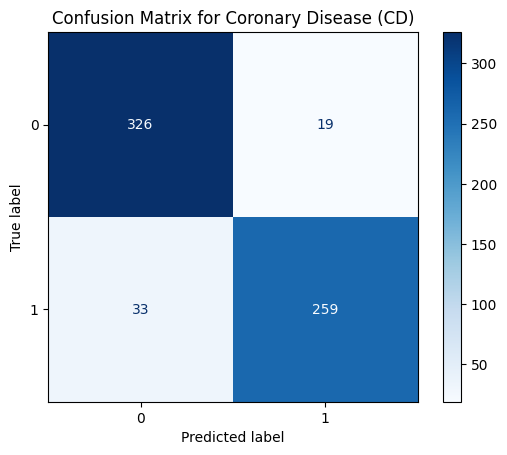

<Figure size 800x600 with 0 Axes>

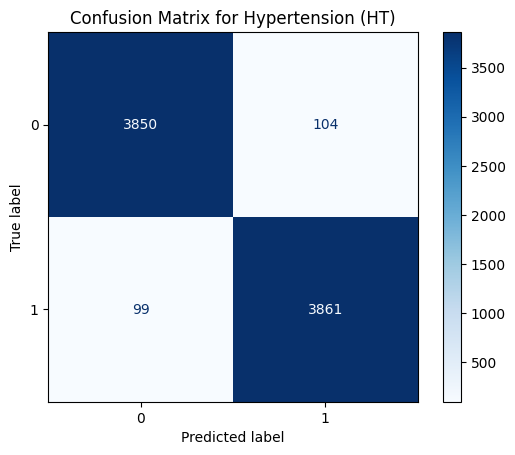

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming the predictions and true labels are already available
# For CD model
y_pred_CD = random_search_CD.best_estimator_.predict(X_test_CD_scaled)
y_pred_HT = voting_clf_HT.predict(X_test_HT_scaled)

# Confusion Matrix for CD model
cm_cd = confusion_matrix(y_test_CD, y_pred_CD)
disp_cd = ConfusionMatrixDisplay(confusion_matrix=cm_cd, display_labels=[0, 1])

# Plot confusion matrix for CD
plt.figure(figsize=(8, 6))
disp_cd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Coronary Disease (CD)')
plt.show()

# Confusion Matrix for HT model
cm_ht = confusion_matrix(y_test_HT, y_pred_HT)
disp_ht = ConfusionMatrixDisplay(confusion_matrix=cm_ht, display_labels=[0, 1])

# Plot confusion matrix for HT
plt.figure(figsize=(8, 6))
disp_ht.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Hypertension (HT)')
plt.show()


#### sample  Model AUC Curve 

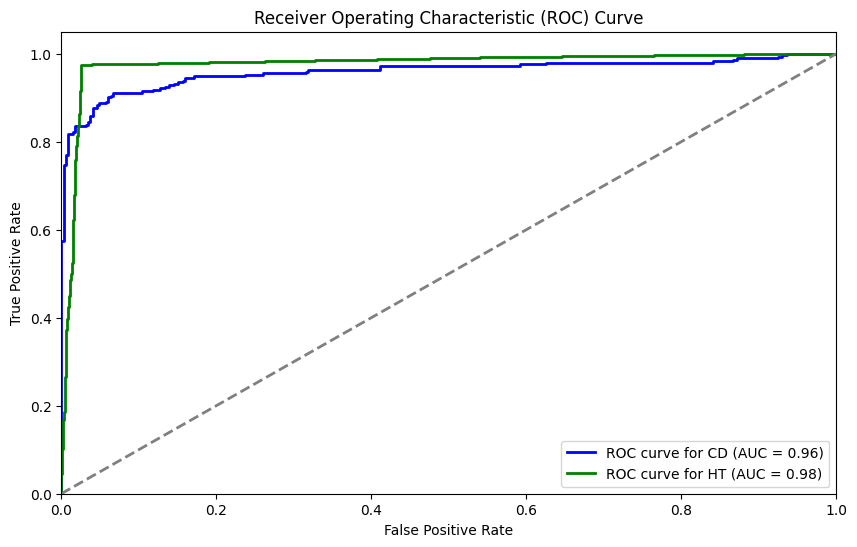

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming your models are already trained and you have your test data and models
# For CD model, predict probabilities for the positive class
y_prob_CD = random_search_CD.best_estimator_.predict_proba(X_test_CD_scaled)[:, 1]
fpr_cd, tpr_cd, _ = roc_curve(y_test_CD, y_prob_CD)
roc_auc_cd = auc(fpr_cd, tpr_cd)

# For HT model, predict probabilities for the positive class
y_prob_HT = voting_clf_HT.predict_proba(X_test_HT_scaled)[:, 1]
fpr_ht, tpr_ht, _ = roc_curve(y_test_HT, y_prob_HT)
roc_auc_ht = auc(fpr_ht, tpr_ht)

# Plotting the ROC curve for CD
plt.figure(figsize=(10, 6))
plt.plot(fpr_cd, tpr_cd, color='blue', lw=2, label=f'ROC curve for CD (AUC = {roc_auc_cd:.2f})')

# Plotting the ROC curve for HT
plt.plot(fpr_ht, tpr_ht, color='green', lw=2, label=f'ROC curve for HT (AUC = {roc_auc_ht:.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [13]:
# For CD (Training accuracy)
y_train_pred_CD = random_search_CD.best_estimator_.predict(X_train_CD_scaled)
train_accuracy_CD = accuracy_score(y_train_CD, y_train_pred_CD)
print(f'Training accuracy for CD: {train_accuracy_CD:.2f}')
# For HT (Training accuracy)
y_train_pred_HT = voting_clf_HT.predict(X_train_HT_scaled)
train_accuracy_HT = accuracy_score(y_train_HT, y_train_pred_HT)
print(f'Training accuracy for HT: {train_accuracy_HT:.2f}')
# For CD (Test accuracy)
y_pred_CD = random_search_CD.best_estimator_.predict(X_test_CD_scaled)
test_accuracy_CD = accuracy_score(y_test_CD, y_pred_CD)
print(f'Test accuracy for CD: {test_accuracy_CD:.2f}')
# For HT (Test accuracy)
y_pred_HT = voting_clf_HT.predict(X_test_HT_scaled)
test_accuracy_HT = accuracy_score(y_test_HT, y_pred_HT)
print(f'Test accuracy for HT: {test_accuracy_HT:.2f}')
#Compare results for both models
print("\nComparison of Training vs Testing Accuracy:")
print(f"CD - Training Accuracy: {train_accuracy_CD:.2f}, Test Accuracy: {test_accuracy_CD:.2f}")
print(f"HT - Training Accuracy: {train_accuracy_HT:.2f}, Test Accuracy: {test_accuracy_HT:.2f}")

Training accuracy for CD: 0.96
Training accuracy for HT: 0.97
Test accuracy for CD: 0.92
Test accuracy for HT: 0.97

Comparison of Training vs Testing Accuracy:
CD - Training Accuracy: 0.96, Test Accuracy: 0.92
HT - Training Accuracy: 0.97, Test Accuracy: 0.97


###### ------------------------------------------------------------------------------------------

#### Final Model (Based on ANOVA and  Chi sqaure value )

In [14]:
# For CD, include only the following features:
selected_features_CD = ['Cholesterol', 'Diastolic_BP', 'Systolic_BP', 'Diabetes', 'Family History']

# For HT, include only the following features:
selected_features_HT = ['Systolic_BP', 'Diastolic_BP', 'Blood_Pressure_Status']

# Convert categorical variables (like 'Sex' and 'Blood_Pressure_Status')
SCDHT_encoded = pd.get_dummies(SCDHT, drop_first=True)

# Separated features (X) and target (y) for both CD and HT
X_CD = SCDHT_encoded[selected_features_CD]
y_CD = SCDHT_encoded['CD']

X_HT = SCDHT_encoded[selected_features_HT]
y_HT = SCDHT_encoded['HT']

# Apply RandomUnderSampler to handle class imbalance
under_sampler_cd = RandomUnderSampler(random_state=42)
X_resampled_CD, y_resampled_CD = under_sampler_cd.fit_resample(X_CD, y_CD)

under_sampler_ht = RandomUnderSampler(random_state=42)
X_resampled_HT, y_resampled_HT = under_sampler_ht.fit_resample(X_HT, y_HT)

# Train-Test Split on Resampled Data
X_train_CD, X_test_CD, y_train_CD, y_test_CD = train_test_split(X_resampled_CD, y_resampled_CD, test_size=0.2, random_state=42)
X_train_HT, X_test_HT, y_train_HT, y_test_HT = train_test_split(X_resampled_HT, y_resampled_HT, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_CD_scaled = scaler.fit_transform(X_train_CD)
X_test_CD_scaled = scaler.transform(X_test_CD)

X_train_HT_scaled = scaler.fit_transform(X_train_HT)
X_test_HT_scaled = scaler.transform(X_test_HT)

# Logistic Regression with L2 regularization
log_clf = LogisticRegression(class_weight='balanced', random_state=42, solver='lbfgs')

# Balanced Random Forest
brf_clf = BalancedRandomForestClassifier(random_state=42)

# SVC with regularization
svm_clf = SVC(probability=True, class_weight='balanced', random_state=42)

# KNN
knn_clf = KNeighborsClassifier()

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Randomized Search for Hyperparameter Tuning
# Define parameter grid for tuning
param_distributions = {
    'lr__C': np.logspace(-2, 2, 5),  # Regularization strength for Logistic Regression
    'svm__C': np.logspace(-2, 2, 5),  # C parameter for SVM
    'knn__n_neighbors': [3, 5, 7, 9],  # Number of neighbors for KNN
    'gb__n_estimators': [100, 200],  # Number of boosting stages
    'gb__learning_rate': [0.01, 0.1, 0.2]  # Learning rate for Gradient Boosting
}

# Voting Classifier for CD with RandomizedSearchCV
voting_clf_CD = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('brf', brf_clf),
    ('svm', svm_clf),
    ('knn', knn_clf),
    ('gb', gb_clf)
], voting='soft')

# Using RandomizedSearchCV to find the best hyperparameters for CD
random_search_CD = RandomizedSearchCV(estimator=voting_clf_CD, param_distributions=param_distributions, 
                                      cv=5, scoring='accuracy', n_iter=20, n_jobs=-1, random_state=42)

# Fit the Voting Classifier for CD
random_search_CD.fit(X_train_CD_scaled, y_train_CD)

# Voting Classifier for HT (without Randomized Search for now)
voting_clf_HT = VotingClassifier(estimators=[
    ('lr', log_clf),
    ('brf', brf_clf),
    ('svm', svm_clf),
    ('knn', knn_clf),
    ('gb', gb_clf)
], voting='soft') #Default weight  is 1 for each model 

# Fit the Voting Classifier for HT
voting_clf_HT.fit(X_train_HT_scaled, y_train_HT)

# Predictions and evaluation for CD
y_pred_CD = random_search_CD.best_estimator_.predict(X_test_CD_scaled)
print(f'Test accuracy for CD: {accuracy_score(y_test_CD, y_pred_CD):.2f}')
print(classification_report(y_test_CD, y_pred_CD))
print(confusion_matrix(y_test_CD, y_pred_CD))

# Predictions and evaluation for HT
y_pred_HT = voting_clf_HT.predict(X_test_HT_scaled)
print(f'Test accuracy for HT: {accuracy_score(y_test_HT, y_pred_HT):.2f}')
print(classification_report(y_test_HT, y_pred_HT))
print(confusion_matrix(y_test_HT, y_pred_HT))


C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
C:\Users\maitreya\anaconda3\envs\r4-base\Lib\site-packages\imblearn\ensemble\_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and ad

Test accuracy for CD: 0.92
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       345
           1       0.91      0.91      0.91       292

    accuracy                           0.92       637
   macro avg       0.92      0.92      0.92       637
weighted avg       0.92      0.92      0.92       637

[[320  25]
 [ 27 265]]
Test accuracy for HT: 0.97
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      3954
           1       0.97      0.97      0.97      3960

    accuracy                           0.97      7914
   macro avg       0.97      0.97      0.97      7914
weighted avg       0.97      0.97      0.97      7914

[[3850  104]
 [  99 3861]]


##### Confuion matrix for final model 

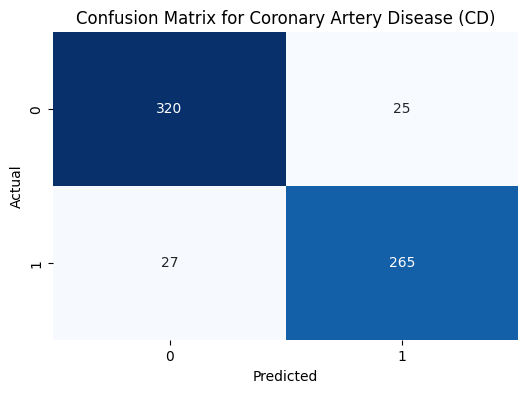

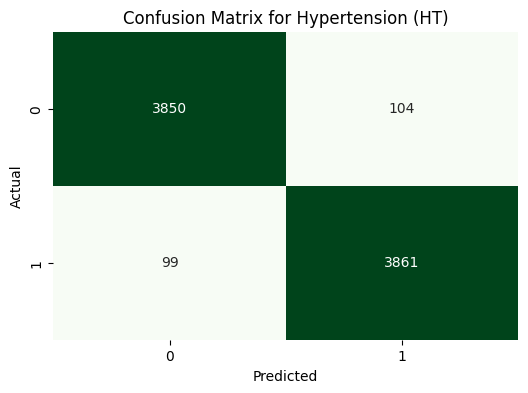

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Plotting confusion matrix for Coronary Artery Disease (CD)
cm_cd = confusion_matrix(y_test_CD, y_pred_CD)
plt.figure(figsize=(6,4))
sns.heatmap(cm_cd, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix for Coronary Artery Disease (CD)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
# Plotting confusion matrix for Hypertension (HT)
cm_ht = confusion_matrix(y_test_HT, y_pred_HT)
plt.figure(figsize=(6,4))
sns.heatmap(cm_ht, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title('Confusion Matrix for Hypertension (HT)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


#### Roc Curve For Final Model 

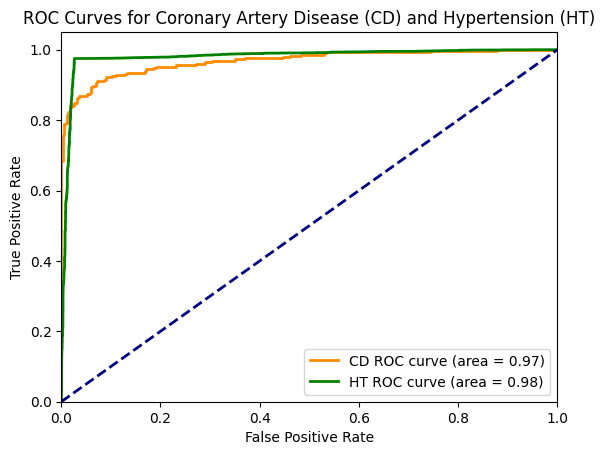

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predictions for CD
y_pred_prob_CD = random_search_CD.best_estimator_.predict_proba(X_test_CD_scaled)[:, 1]  # Get probabilities for the positive class (CD)
fpr_cd, tpr_cd, _ = roc_curve(y_test_CD, y_pred_prob_CD)
roc_auc_cd = auc(fpr_cd, tpr_cd)

# Predictions for HT
y_pred_prob_HT = voting_clf_HT.predict_proba(X_test_HT_scaled)[:, 1]  # Get probabilities for the positive class (HT)
fpr_ht, tpr_ht, _ = roc_curve(y_test_HT, y_pred_prob_HT)
roc_auc_ht = auc(fpr_ht, tpr_ht)

# Plotting both ROC Curves on the same plot
plt.figure()

# Plot ROC curve for CD
plt.plot(fpr_cd, tpr_cd, color='darkorange', lw=2, label=f'CD ROC curve (area = {roc_auc_cd:.2f})')

# Plot ROC curve for HT
plt.plot(fpr_ht, tpr_ht, color='green', lw=2, label=f'HT ROC curve (area = {roc_auc_ht:.2f})')

# Reference line for random chance
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Plot settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Coronary Artery Disease (CD) and Hypertension (HT)')
plt.legend(loc="lower right")
plt.show()


In [17]:
##### Final Model TRaining vs Testing Accuracy 

In [18]:
from sklearn.metrics import accuracy_score

# Voting Classifier for CD (best model from RandomizedSearchCV)
# Training accuracy for CD
y_train_pred_CD = random_search_CD.best_estimator_.predict(X_train_CD_scaled)
train_accuracy_CD = accuracy_score(y_train_CD, y_train_pred_CD)

# Testing accuracy for CD (already computed)
test_accuracy_CD = accuracy_score(y_test_CD, y_pred_CD)

print(f"Training accuracy for CD: {train_accuracy_CD:.2f}")
print(f"Testing accuracy for CD: {test_accuracy_CD:.2f}")

# Voting Classifier for HT
# Training accuracy for HT
y_train_pred_HT = voting_clf_HT.predict(X_train_HT_scaled)
train_accuracy_HT = accuracy_score(y_train_HT, y_train_pred_HT)

# Testing accuracy for HT (already computed)
test_accuracy_HT = accuracy_score(y_test_HT, y_pred_HT)

print(f"Training accuracy for HT: {train_accuracy_HT:.2f}")
print(f"Testing accuracy for HT: {test_accuracy_HT:.2f}")


Training accuracy for CD: 0.94
Testing accuracy for CD: 0.92
Training accuracy for HT: 0.97
Testing accuracy for HT: 0.97


In [19]:
#Compare results for both models
print("\nComparison of Training vs Testing Accuracy:")
print(f"CD - Training Accuracy: {train_accuracy_CD:.2f}, Test Accuracy: {test_accuracy_CD:.2f}")
print(f"HT - Training Accuracy: {train_accuracy_HT:.2f}, Test Accuracy: {test_accuracy_HT:.2f}")


Comparison of Training vs Testing Accuracy:
CD - Training Accuracy: 0.94, Test Accuracy: 0.92
HT - Training Accuracy: 0.97, Test Accuracy: 0.97


##### ------------------------------------------------------------------------------------------------------------------------------------------------

###  Creating  Pikle File 

#### Saving the models as pkl file 

In [20]:
import pickle

# Save the trained CD model (after hyperparameter tuning with RandomizedSearchCV)
with open('voting_clf_CD.pkl', 'wb') as file_cd:
    pickle.dump(random_search_CD.best_estimator_, file_cd)  # Use the best estimator from RandomizedSearchCV

# Save the trained HT model
with open('voting_clf_HT.pkl', 'wb') as file_ht:
    pickle.dump(voting_clf_HT, file_ht)


##### Loading the models 

In [21]:
# Load the CD model
with open('voting_clf_CD.pkl', 'rb') as file_cd:
    cd_model = pickle.load(file_cd)
    print("CD model loaded successfully from pickle file.")

# Load the HT model
with open('voting_clf_HT.pkl', 'rb') as file_ht:
    ht_model = pickle.load(file_ht)
    print("HT model loaded successfully from pickle file.")


CD model loaded successfully from pickle file.
HT model loaded successfully from pickle file.


In [22]:
import joblib

# Save the trained CD model (after hyperparameter tuning with RandomizedSearchCV)
joblib.dump(random_search_CD.best_estimator_, 'voting_clf_CD.joblib')
print("CD model saved successfully using Joblib.")

# Save the trained HT model
joblib.dump(voting_clf_HT, 'voting_clf_HT.joblib')
print("HT model saved successfully using Joblib.")

# Load the CD model
cd_model = joblib.load('voting_clf_CD.joblib')
print("CD model loaded successfully from Joblib file.")

# Load the HT model
ht_model = joblib.load('voting_clf_HT.joblib')
print("HT model loaded successfully from Joblib file.")


CD model saved successfully using Joblib.
HT model saved successfully using Joblib.
CD model loaded successfully from Joblib file.
HT model loaded successfully from Joblib file.


In [23]:
import joblib

# Load the CD model
cd_model = joblib.load('voting_clf_CD.joblib')
print("CD model loaded successfully from Joblib file.")

# Load the HT model
ht_model = joblib.load('voting_clf_HT.joblib')
print("HT model loaded successfully from Joblib file.")

# Combine the models into a dictionary
combined_models = {
    'voting_clf_CD': cd_model,
    'voting_clf_HT': ht_model
}
# Save the combined models into a single joblib file
joblib.dump(combined_models, 'combined_models.joblib')
print("Combined models saved successfully in 'combined_models.joblib'.")
# To verify, load the combined models and access them
loaded_models = joblib.load('combined_models.joblib')
print("Combined models loaded successfully.")
# Access individual models
cd_loaded = loaded_models['voting_clf_CD']
ht_loaded = loaded_models['voting_clf_HT']
print("CD model and HT model extracted from combined file.")


CD model loaded successfully from Joblib file.
HT model loaded successfully from Joblib file.
Combined models saved successfully in 'combined_models.joblib'.
Combined models loaded successfully.
CD model and HT model extracted from combined file.


In [24]:
#pip install scikit-learn==1.4.1.post1


In [25]:
#pip install numpy==1.26.4


In [26]:
import pandas as pd
import scipy
import numpy as np
import matplotlib
import plotly
import sklearn
import imblearn
import seaborn as sns
import ctgan
import joblib
import pickle
import dash

# Print the versions
print(f"pandas version: {pd.__version__}")
print(f"scipy version: {scipy.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"plotly version: {plotly.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"imblearn version: {imblearn.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"ctgan version: {ctgan.__version__}")
print(f"joblib version: {joblib.__version__}")
print(f"pickle version: {pickle.format_version}")  # pickle doesn't have __version__, format_version shows its protocol
print(f"dash version: {dash.__version__}")


pandas version: 2.2.1
scipy version: 1.11.4
numpy version: 1.26.4
matplotlib version: 3.9.2
plotly version: 5.23.0
scikit-learn version: 1.5.2
imblearn version: 0.12.3
seaborn version: 0.13.2
ctgan version: 0.10.1
joblib version: 1.4.2
pickle version: 4.0
dash version: 2.18.1


In [27]:
import sys
print(f"Python version: {sys.version}")


Python version: 3.11.7 | packaged by Anaconda, Inc. | (main, Dec 15 2023, 18:05:47) [MSC v.1916 64 bit (AMD64)]


In [28]:
import flask
print(f"Flask version: {flask.__version__}")



Flask version: 2.2.2


In [29]:
import warnings
import joblib

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    combined_models = joblib.load('combined_models.joblib')


In [30]:
#pip install scikit-learn==1.5.2


Note: you may need to restart the kernel to use updated packages.
